# k-nearest-Neighbour

## Load datasets

2024-12-17 16:13:06.643918: I tensorflow/core/kernels/data/tf_record_dataset_op.cc:376] The default buffer size is 262144, which is overridden by the user specified `buffer_size` of 8388608
2024-12-17 16:13:10.542064: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Total Image count:  500


2024-12-17 16:13:13.121034: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Train Dataset Size: 375
Test Dataset Size: 125


2024-12-17 16:13:16.808621: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


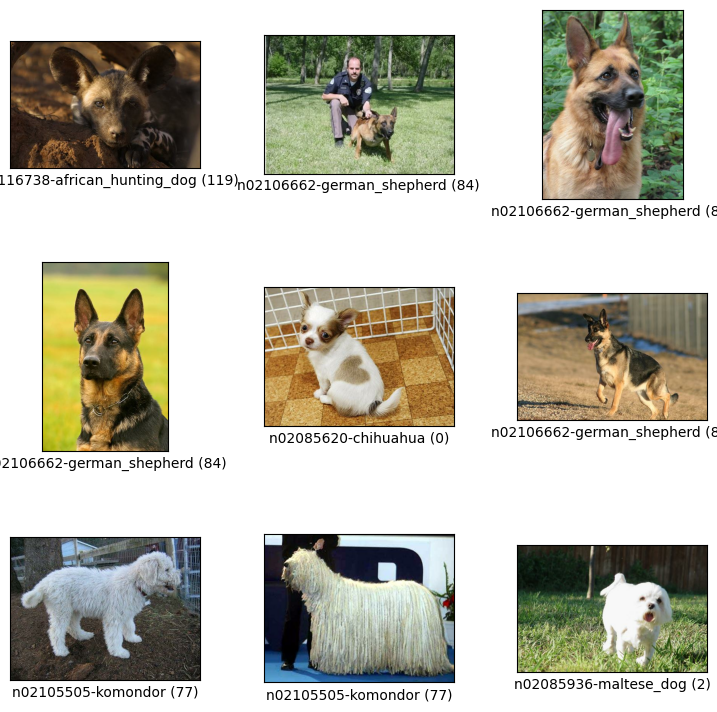

/Users/jannisgehring/VSCode/ml-lecture/utils/setup.py:43: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


,image,image/filename,label,objects/bbox
0,,Images/n02116738-African_hunting_dog/n02116738_8037.jpg,119 (n02116738-african_hunting_dog),
1,,Images/n02106662-German_shepherd/n02106662_13380.jpg,84 (n02106662-german_shepherd),
2,,Images/n02106662-German_shepherd/n02106662_26549.jpg,84 (n02106662-german_shepherd),
3,,Images/n02106662-German_shepherd/n02106662_320.jpg,84 (n02106662-german_shepherd),

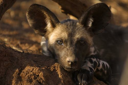
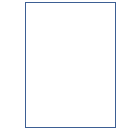
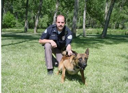
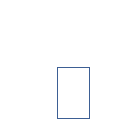
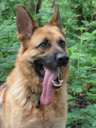
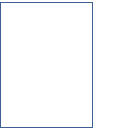
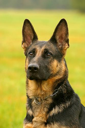
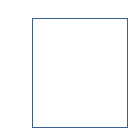

In [1]:
import tensorflow_datasets as tfds
import tensorflow as tf
from pathlib import Path
import sys

notebook_dir = Path().resolve()
sys.path.append(str(notebook_dir.parent))

from utils.setup import setup_dataset


train_dataset, test_dataset, table, info = setup_dataset('../dataset', show_examples=True)

## Merkmale
Die folgenden Merkmale wurden zur Merkmalsextraktion definiert:
https://gvpress.com/journals/IJMUE/vol8_no4/39.pdf

Farb-merkmale:
1. Helligkeit des Fells
2. Farbvarianz des Fells

Textur-merkmale:

3. Fellstruktur

Form-merkmale:

4. Form des Hunds auf dem Bild




Ideen:
- Histogramm
    - Maximaler Wert
    - Median
    - Mittelwert
    - Kurtosis
- Rechtecke
    - Anzahl der gefundenen Regionen
    - Avg(Höhe)/Avg(Breite)
    - Avg(Höhe)
    - Avg(Breite)

- 



# Creating feature vector

In [24]:
from skimage.feature import local_binary_pattern, multiblock_lbp
import scipy.stats as ss
from skimage.measure import regionprops_table
import matplotlib.patches as mpatches
from skimage.morphology import label as skimage_label
from skimage.feature import canny
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

def colorTensor2grayNparray(image):
    return tf.image.rgb_to_grayscale(image).cpu().numpy()[:,:,0]

def computeHistogrammFeatures(img):
    values, _ = np.histogram(img, bins=np.arange(256))
    nobs, minmax, mean, variance, skewness, kurtosis = ss.describe(values)
    return mean, skewness, kurtosis

def computeRegionFeatures(img):
    img_grayscale_np = colorTensor2grayNparray(img)

    edges = canny(img_grayscale_np)
    label_image = skimage_label(edges)

    properties=("bbox", "area_bbox", "axis_major_length", "axis_minor_length", "orientation", "solidity")
    regions = regionprops_table(label_image,properties=properties)
    df = pd.DataFrame(regions)

    num_regions = df.shape[0]
    df["bbox_height_width_ratio"] = (df["bbox-3"]-df["bbox-1"])/(df["bbox-2"]-df["bbox-0"])
    df["axis_ratio"] = (df["axis_major_length"])/(df["axis_minor_length"])
    df = df.drop(columns=["bbox-0","bbox-1", "bbox-2", "bbox-3"])
    df = df.describe()
    #return df
    return (
        num_regions,
        df.at["mean", "bbox_height_width_ratio"],
        df.at["mean", "area_bbox"],
        df.at["mean", "axis_major_length"],
        df.at["mean", "axis_minor_length"],
        df.at["std", "orientation"],
    )

def computeLBPfeatures(img):
    img_grayscale_np = colorTensor2grayNparray(img)
    radius = 3
    n_points = radius*8
    lbp = local_binary_pattern(img_grayscale_np, n_points, radius)
    hist, _ = np.histogram(lbp.ravel(), bins=np.arange(3,n_points+3), range=(5, n_points+2))
    hist = hist.astype("float")
    hist/=hist.sum()
    #plt.bar(range(len(hist)), hist)
    #plt.show()
    sorted_with_index = sorted(enumerate(hist), key=lambda x: -x[1])
    max_values_indices = [index for index, value in sorted_with_index]
    return (
        *max_values_indices[:4],
    )

images = [sample["image"] for sample in train_dataset.take(5)]
labels = [sample["label"] for sample in train_dataset.take(5)]

i = 0
print(labels[i])
computeRegionFeatures(images[i])

tf.Tensor(119, shape=(), dtype=int64)


/Users/jannisgehring/VSCode/ml-lecture/.venv/lib/python3.10/site-packages/pandas/core/nanops.py:1016: RuntimeWarning: invalid value encountered in subtract
  sqr = _ensure_numeric((avg - values) ** 2)


(472,
 1.2985547294557966,
 283.7478813559322,
 18.10982730749499,
 5.8946095726223655,
 0.8914097408961325)

In [26]:
import numpy as np

# Feature Extraction

def imageToVector(img) -> np.ndarray:
    extractionMethods = (
        computeHistogrammFeatures,
        computeRegionFeatures,
        computeLBPfeatures
    )
    vector = []
    for method in extractionMethods:
        features = method(img)
        vector+=features
    return np.array(vector)

def datasetToVectorLabels(dataset):
    vectors, labels = [], []
    for sample in dataset:
        vectors.append(imageToVector(sample["image"].numpy()))
        labels.append(sample["label"].numpy())
    vectors = np.array(vectors)
    return vectors, labels

x_train, y_train = datasetToVectorLabels(train_dataset)
x_test, y_test = datasetToVectorLabels(test_dataset)

/Users/jannisgehring/VSCode/ml-lecture/.venv/lib/python3.10/site-packages/pandas/core/nanops.py:1016: RuntimeWarning: invalid value encountered in subtract
  sqr = _ensure_numeric((avg - values) ** 2)
/Users/jannisgehring/VSCode/ml-lecture/.venv/lib/python3.10/site-packages/pandas/core/nanops.py:1016: RuntimeWarning: invalid value encountered in subtract
  sqr = _ensure_numeric((avg - values) ** 2)
/Users/jannisgehring/VSCode/ml-lecture/.venv/lib/python3.10/site-packages/pandas/core/nanops.py:1016: RuntimeWarning: invalid value encountered in subtract
  sqr = _ensure_numeric((avg - values) ** 2)
/Users/jannisgehring/VSCode/ml-lecture/.venv/lib/python3.10/site-packages/pandas/core/nanops.py:1016: RuntimeWarning: invalid value encountered in subtract
  sqr = _ensure_numeric((avg - values) ** 2)
/Users/jannisgehring/VSCode/ml-lecture/.venv/lib/python3.10/site-packages/pandas/core/nanops.py:1016: RuntimeWarning: invalid value encountered in subtract
  sqr = _ensure_numeric((avg - values) *

In [30]:
# Hyper parameters
n_neighbors=7
feature_selection = True
n_features_to_select = 6
feature_reduction = True

In [34]:
from sklearn.pipeline import Pipeline
from sklearn import set_config
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.decomposition import PCA
from sklearn.feature_selection import SequentialFeatureSelector
from sklearn.base import TransformerMixin, BaseEstimator

class Debug(BaseEstimator, TransformerMixin):
    df = pd.DataFrame()
    def transform(self, X):
        print(pd.DataFrame(X).head())
        print(X.shape)
        return X

    def fit(self, X, y=None, **fit_params):
        return self

# Create Pipeline
knn = KNeighborsClassifier(n_neighbors=n_neighbors)
sfs = SequentialFeatureSelector(estimator=knn,n_features_to_select=n_features_to_select)
possible_steps=[
    ("scaler",              StandardScaler(),   True),
    ("dbg",                 Debug(),            True),
    ("sequential_selector", sfs,                feature_selection),
    ("dbg2",                Debug(),            True),
    ("pca",                 PCA(n_components=2),feature_reduction),
    ("dbg3",                Debug(),            True),
    ("knn",                 knn,                True),
]
steps = [ (name, function) for (name, function, enabled) in possible_steps if enabled]
pipeline = Pipeline(steps=steps)
# Fit pipeline
pipeline.fit(x_train, y_train)


set_config(display="diagram")
pipeline

False
         0         1         2         3         4         5         6   \
0 -0.118993 -0.180318 -0.367303 -0.409781 -0.354911 -0.266160 -0.236580   
1 -0.383589 -0.804815 -0.404302 -0.070791  0.046222 -0.454811 -0.843984   
2 -0.032341 -0.557574 -0.414075  0.342639  0.142662 -0.435202  0.025222   
3 -0.118993 -0.313630 -0.362675 -0.232269 -0.591182 -0.462048 -0.902872   
4 -0.141720 -0.575255 -0.405425  0.121609  0.093980 -0.180306 -0.506076   

         7         8         9         10        11        12  
0  0.554128 -0.363981 -0.823175  0.350732 -0.721256  0.490960  
1  0.181154  0.143130  1.068311 -0.880772 -0.721256  2.030912  
2 -0.091586  0.533406 -0.823175  0.104432 -0.574101 -0.022358  
3 -0.717398 -0.587349 -0.823175  0.350732  0.455984 -0.022358  
4  1.153379  0.906474 -0.823175  0.350732 -0.868411 -0.877887  
(375, 13)
          0         1         2         3         4         5
0 -0.118993 -0.367303 -0.409781 -0.363981 -0.823175  0.490960
1 -0.383589 -0.404302 -0.

Pipeline(steps=[('scaler', StandardScaler()), ('dbg', Debug()),
                ('sequential_selector',
                 SequentialFeatureSelector(estimator=KNeighborsClassifier(n_neighbors=7),
                                           n_features_to_select=6)),
                ('dbg2', Debug()), ('pca', PCA(n_components=2)),
                ('dbg3', Debug()),
                ('knn', KNeighborsClassifier(n_neighbors=7))])

In [32]:
# Test pipeline on test data
pipeline.score(x_test, y_test)

         0         1         2         3         4         5         6   \
0 -0.118993  3.639062  4.081210  0.894643 -0.676858 -0.834704 -1.288915   
1 -0.032341  1.396478  0.958493 -0.481930  0.196916  0.791430  0.774756   
2 -0.118993 -0.114202 -0.349702 -0.050177 -0.224014 -0.713583 -0.706820   
3 -0.121056 -0.442251 -0.373076  0.096414 -0.831242 -0.157140 -0.584900   
4 -0.311359 -0.931666 -0.361702 -0.149812  0.304800 -0.715568 -0.565034   

         7         8         9         10        11        12  
0 -0.620530 -0.636781  1.068311  4.291544 -1.309875 -0.022358  
1  0.390088  0.072130 -0.823175  0.350732 -0.721256 -0.022358  
2  1.103942  0.514240  1.068311 -0.880772 -0.721256 -0.022358  
3 -0.275311 -1.247036  1.068311 -0.880772 -0.721256  2.030912  
4 -0.157949  0.241657 -0.823175  0.104432 -0.574101  0.490960  
(125, 13)
          0         1         2         3         4         5
0 -0.118993  4.081210  0.894643 -0.636781  1.068311 -0.022358
1 -0.032341  0.958493 -0.481930

0.224